In [2]:
from cgi import test
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import copy
from sklearn.model_selection import train_test_split
from scipy.stats import halfnorm, expon, uniform, chi, norm
import keras
from keras import callbacks
from keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add
from keras.layers import Activation, Dropout, Flatten, Embedding
from keras.models import Model, Sequential
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats
from IPython.display import display

### Exponential distribution generators

In [3]:
def generate_exponential(amount): #Generates a popular playlist
    data = {}
    for i in range(amount):
        data[i] = expon.pdf(i, scale=(amount/7)) 
    return data  

In [4]:
def generate_exponential_inv(amount): #Generates a "niche" (unpopuar) playlist 
    data = {}
    for i in range(amount):
        data[amount - 1 - i] = expon.pdf(i, scale=(amount/7)) 
    return data

### Uniform distribution generator

In [5]:
def generate_uniform(amount): #Generates an uniform distribution among the items
    data = {}
    for i in range(amount):
        data[i] = uniform.pdf(i, scale=amount) 
    return data

### Aux functions

get_cumulative_prob() GETS THE CUMULATIVE PROBABIITIES OF ITEMS (for later selection)

In [6]:
def get_cumulative_prob(y): 

    cum_prob = {}
    cum_prob[0] = y[0]

    for i in range(1, 300):
        cum_prob[i] = cum_prob[i-1] + y[i]
    return cum_prob

get_playlist() generates a playlist based on the cumulative probabilities its given (for popualar, normal, and rare)

In [7]:
def get_playlists(cum_prob): #CREATES A RANDOM PLAYLLIST

    playlist = [] #empty toy playlist

    #create random playlist (like this bc they dont add to 1)
    while len(playlist) < 20:

        prob = np.random.random()
        #print(prob)
        finished = False
        i = 0
        while i < 300 and finished == False:
            if prob < cum_prob[i] and i not in playlist:
                playlist.append(i)
                finished = True
            i += 1

    playlist.sort()
    return playlist

In [8]:
def get_songs_ordered(songs): #RETURNS A LIST OF SONGS ORDERED BY POPULARITY (AMONG ALL THE PLAYLISTS)
    ordered_songs = []
    songs_copy = copy.deepcopy(songs)

    while songs_copy: 
        max_value = max(songs_copy, key=songs_copy.get)
        ordered_songs.append(max_value)
        songs_copy.pop(max_value)
    #print("Highest used song: ", max_value, " with ", songs_copy[max_value], " instances")
    return ordered_songs

In [9]:
def create_dataframe(list): 
    elems = []
    pred = []
    size = len(list)
    for i in range(size - 1):
        elems.append(list[i])
        pred.append(list[i + 1])
    d = {'Song':elems, 'Next':pred}
    df = pd.DataFrame(d)
    return df

In [10]:
def get_prob_dataframe(probs):
    songs = []
    next = []
    for i in range(len(probs)):
        songs.append(i)
        next.append(probs[i])
    for i in range(len(next[299])):
        next[299][i] = 0
    next[299][298] = 1
    dataframe_next = pd.DataFrame(next)
    d = {'Song': songs}
    df = pd.DataFrame(d)
    result = pd.concat([df, dataframe_next], axis=1, join='inner')
    return result

In case we stop using probabilities use this function not create_dataframe()

In [11]:
def create_training_data(pairs):
    songs = []
    next = []
    for i in range(len(pairs)):
        #max_num = 0
        songs.append(i)
        #max_num = max(pairs[i])
        pred_song = np.argmax(pairs[i])
        next.append(pred_song)
    d = {"Song":songs, "Next":next}
    df = pd.DataFrame(d)
    return df

In [12]:
def split_dataset(dataframe):
    X = dataframe['Song']
    y = dataframe['Next']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    train = {'Song':X_train, 'Next': y_train}
    test = {'Song':X_test, 'Next': y_test}
    return train, test

In [13]:
def split_dataset2(dataframe):
    X = dataframe['Song']
    y = dataframe['Next']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test

In [14]:
def split_dataset_prob(dataframe):
    X = dataframe['Song']
    dataframe = dataframe.drop('Song', axis=1)
    y = dataframe

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    X_train = X
    y_train = y
    return X_train, X_test, y_train, y_test

In [15]:
def norm_data(data, mean, std):
    songs_norm = (data['Song'] - mean) / std
    data['Song'] = songs_norm
    return data

In case we need tensorflow Datasets

In [16]:
def get_tf_dataset(train, test):
    train_X = tf.data.Dataset.from_tensor_slices(train['Song'])
    train_Y = tf.data.Dataset.from_tensor_slices(train['Next'])

    train_dataset = tf.data.Dataset.zip((train_X, train_Y))
    train_dataset = train_dataset.shuffle(1000).batch(64)
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    test_X = tf.data.Dataset.from_tensor_slices(test['Song'])
    test_Y = tf.data.Dataset.from_tensor_slices(test['Next'])

    test_dataset = tf.data.Dataset.zip((test_X, test_Y))
    test_dataset = test_dataset.shuffle(1000).batch(64)
    test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, test_dataset

create_pairs() creates pairs of numbers, indicating the number of times one appears after the other in the playlists

In [17]:
def create_pairs(playlists): #playlists should be a list of lists, ordered
    pairs = np.zeros((300,300))
    for playlist in playlists:
        for i in range(len(playlist)-1):
            pairs[playlist[i]][playlist[i+1]] += 1
    return pairs

In [18]:
def order_playists(playlists):
    for playlist in playlists:
        playlist.sort()
    return playlists

In [19]:
def get_probabilities(pairs): #Gets the probabilities associated to each pair of numbers, which song is more likely
    for num in range(len(pairs)): #to go after the other
        total = sum(pairs[num])
        pairs[num] /= total
    return pairs

In [20]:
def get_nll(true_song, probs): #true_song has to be in [0,0,0...1,0] format, being the 1 in the correct song index
    nll = 0                     #probs is the output of the nn
    for i in range(len(true_song)):
        nll += true_song[i] * probs[i]
    nll = -np.log(nll)
    return nll

In [21]:
def get_nll_list(expected, idx, predictions): #Returns a list of uncertainties for each prediction
    nll_list = []
    j = 0
    for i in idx:
        true_song = get_true_song(expected[i])
        nll_list.append(get_nll(true_song, predictions[j]))
        j += 1
    return nll_list

In [22]:
def get_true_song(next_songs): #returns expected song, represented as one_hot
    true_song = []
    item = np.argmax(next_songs)
    for i in range(len(next_songs)):
        if i == item:
            true_song.append(1)
            #print("Predicted song: ", item)
        else:
            true_song.append(0)
    return true_song

In [23]:
def transform_predictions(pred): #Transforms the predictions into a one_hot of the most likely song
    max_index = np.argmax(pred)
    new_pred = np.zeros(len(pred))
    new_pred[max_index] = 1
    return new_pred

In [24]:
def get_accuracy(pred, truth):
    count = 0
    size = len(pred)
    for i in range(size):
        cont = True
        j = 0
        while cont and j < size:
            if pred[i][j] != truth[i][j]:
                cont = False
            j += 1
        if cont:
            count += 1
    return count / size

### Model creation

In [160]:
def create_model():
    model = Sequential()
    input = Input(shape=(1,))
    model.add(input)
    """model.add(Dense(10, activation='tanh'))
    model.add(Dense(20, activation='tanh'))
    model.add(Dense(30, activation='tanh'))
    model.add(Dense(40, activation='tanh'))
    model.add(Dense(50, activation='tanh'))
    model.add(Dense(60, activation='tanh'))
    model.add(Dense(40, activation='tanh'))
    model.add(Dense(70, activation='tanh'))"""
    model.add(Dense(1, activation='relu')) #model.add(Dense(1))
    return model

### Visualization functions

In [26]:
def plot_playists_popularity(playists): #FUNCTION THAT PLOTS AL THE SONGS APPEARANCES OF ALL PLAYLISTS
    #playlists is a list of lists

    num_appearances = {} #Dictionary to store the number of times a song is in a playlist

    for playlist in playists:
        for song in playlist:
            if song in num_appearances.keys():
                num_appearances[song] += 1
            else:
                num_appearances[song] = 1

    id, counts = zip(*num_appearances.items())
    plt.scatter(id, counts)
    plt.xlabel("Song number")
    plt.ylabel("Number of appearances")
    plt.show() #BREAK POINT HERE TO SEE THE PLOT
    return num_appearances

In [27]:
def plot_uncertainty_pop(popuarity, uncertainty):
    id, counts = zip(*popuarity.items())
    plot_dict = {}
    i = 0
    for num in counts:
        #what if its already a number
        plot_dict[num] = uncertainty[i]
        i += 1
    pop, unc = zip(*plot_dict.items())
    print(scipy.stats.pearsonr(pop, unc))
    print(scipy.stats.spearmanr(pop, unc))
    print(scipy.stats.kendalltau(pop, unc))
    plt.scatter(pop, unc)
    plt.xlabel("Popuarity")
    plt.ylabel("Uncertainty")
    plt.show() #BREAK POINT HERE TO SEE THE PLOT

## Here it begins

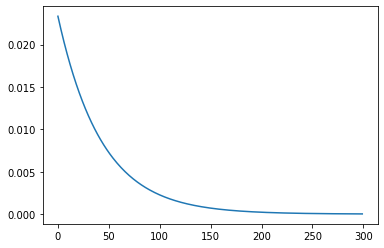

In [28]:
data = generate_exponential(300)
#data = generate_exponential_inv(300)
#data = generate_uniform(300)
lists = sorted(data.items())
x, y = zip(*lists)
cum_prob = get_cumulative_prob(y)
playlist = get_playlists(cum_prob)
plt.plot(x, y)
plt.show() 

In [29]:
random.seed(1234)
playlist_list = []
data_exp = generate_exponential(300)
data_exp_inv = generate_exponential_inv(300)
data_uniform = generate_uniform(300)

data_exp = sorted(data_exp.items())
_, y_exp = zip(*data_exp)

data_exp_inv = sorted(data_exp_inv.items())
_, y_exp_inv = zip(*data_exp_inv)

data_uniform = sorted(data_uniform.items())
_, y_uni = zip(*data_uniform)

In [30]:
type = random.choices(population=[0,1,2], weights=[0.2307,0.6923,0.077], k=3000) #returns a list of choices

cum_prob_exp = get_cumulative_prob(y_exp) #GETS DIFFERENT PROBABIITIES
cum_prob_inv = get_cumulative_prob(y_exp_inv)
cum_prob_uni = get_cumulative_prob(y_uni)

for i in type: #GET A RANDOM PLAYLIST OF A SPECIFIC TYPE
    if i == 1:
        pl = get_playlists(cum_prob_exp)
    elif i == 2:
        pl = get_playlists(cum_prob_inv)
    else:
        pl = get_playlists(cum_prob_uni)
    playlist_list.append(pl)

In [157]:
song = []
next_song = []

for playlist in playlist_list:
    for i in range(len(playlist)):
        song.append(playlist[i])
        if i == len(playlist) - 1:
            next_song.append(playlist[0])
        else: next_song.append(playlist[i+1])

X_train3, X_test3, y_train3, y_test3 = train_test_split(song, next_song, test_size=0.2)

d = {'song': song, 'next': next_song}
new_df = pd.DataFrame(d)
new_df
    

,song,next
0,196,199
1,199,200
2,200,207
3,207,208
4,208,231
...,...,...
59995,65,66
59996,66,78
59997,78,113
59998,113,178


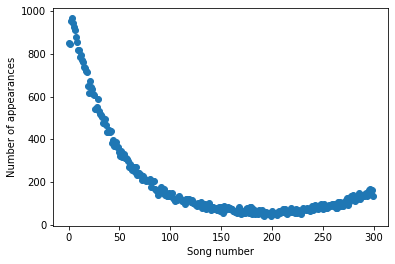

C:\Users\danie\AppData\Local\Temp\ipykernel_9652\4282934075.py:4: RuntimeWarning: invalid value encountered in true_divide
  pairs[num] /= total


In [31]:
popuarity = plot_playists_popularity(playlist_list) #returns the number of appearances of each song
playlists_ordered = order_playists(playlist_list)
pairs = create_pairs(playlist_list) #playlists_ordered
pairs2 = get_probabilities(pairs)
df2 = get_prob_dataframe(pairs2)
df = create_training_data(pairs)

In [32]:
train_data, test_data= split_dataset(df)
#X_train, X_test, y_train, y_test = split_dataset2(df)
X_train, X_test, y_train, y_test = split_dataset_prob(df2)
train_dataset, test_dataset = get_tf_dataset(train_data, test_data)

In [33]:
model = create_model()
callback1 = callbacks.EarlyStopping(monitor='loss', patience=5)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#history = model.fit(train_dataset, epochs=1000, validation_data=test_dataset, verbose=1)
history = model.fit(x=X_train, y=y_train, batch_size=1, epochs=200, validation_data=(X_test,y_test))

Epoch 1/200
300/300 [==============================] - 1s 1ms/step - loss: 5.5673 - accuracy: 0.0033 - val_loss: 5.5832 - val_accuracy: 0.0000e+00
Epoch 2/200
300/300 [==============================] - 0s 840us/step - loss: 5.1857 - accuracy: 0.0033 - val_loss: 5.3960 - val_accuracy: 0.0000e+00
Epoch 3/200
300/300 [==============================] - 0s 844us/step - loss: 5.0184 - accuracy: 0.0000e+00 - val_loss: 5.0623 - val_accuracy: 0.0000e+00
Epoch 4/200
300/300 [==============================] - 0s 823us/step - loss: 4.8568 - accuracy: 0.0000e+00 - val_loss: 4.6697 - val_accuracy: 0.0000e+00
Epoch 5/200
300/300 [==============================] - 0s 810us/step - loss: 4.9954 - accuracy: 0.0000e+00 - val_loss: 4.6889 - val_accuracy: 0.0167
Epoch 6/200
300/300 [==============================] - 0s 820us/step - loss: 4.8392 - accuracy: 0.0133 - val_loss: 4.6669 - val_accuracy: 0.0333
Epoch 7/200
300/300 [==============================] - 0s 823us/step - loss: 4.6566 - accuracy: 0.0000e+

0.02666666666666667
(-0.08122270441960236, 0.28667682682952317)
SpearmanrResult(correlation=-0.44920299552948545, pvalue=5.05961624900571e-10)
KendalltauResult(correlation=-0.3145970367417448, pvalue=7.151375973877701e-10)


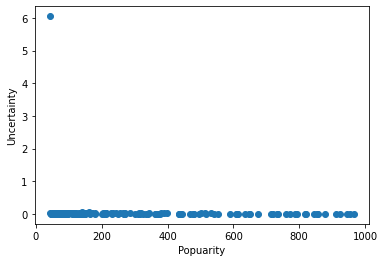

[[3.6744177e-03 9.9978751e-01 9.9992645e-01 ... 1.4407933e-02
  5.1079094e-03 6.5063536e-03]
 [2.3563802e-03 9.9977505e-01 9.9992120e-01 ... 1.5431941e-02
  5.3752661e-03 7.0795119e-03]
 [1.0069311e-03 9.9972224e-01 9.9989557e-01 ... 1.6165316e-02
  5.5902898e-03 7.6647401e-03]
 ...
 [2.9609400e-05 7.4529648e-04 4.8550963e-04 ... 9.9116081e-01
  9.9579906e-01 9.9575275e-01]
 [2.9627619e-05 7.4496865e-04 4.8524141e-04 ... 9.9116403e-01
  9.9580109e-01 9.9575424e-01]
 [2.9645425e-05 7.4467063e-04 4.8509240e-04 ... 9.9116719e-01
  9.9580312e-01 9.9575561e-01]]


In [34]:
nums = list(range(0,300))
pred = model.predict(nums)
new_pred = []
real_values = []
i = 0
for item in pred:
    new_pred.append(transform_predictions(item))
    real_values.append(transform_predictions(y_train[i]))
    i += 1
print(get_accuracy(new_pred, real_values))
uncertainty = get_nll_list(y_train, nums, pred)
plot_uncertainty_pop(popuarity, uncertainty)
print(pred)

# Test on bayesian probabilistic model

In [35]:
def run_experiment(model, loss, X_train, X_test, y_train, y_test):

    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError(), 'accuracy'],
    )
    callback = callbacks.EarlyStopping(monitor='val_acc', patience=5)
    print("Start training the model...")
    history = model.fit(x=X_train, y=y_train, epochs=150, validation_data=(X_test, y_test))
    print("Model training finished.")
    #print(model.metrics_names)
    _, rmse, _ = model.evaluate(x=X_train, y=y_train, verbose=0)
    print(f"Train RMSE: {round(rmse, 3)}")

    print("Evaluating model performance...")
    _, rmse, _ = model.evaluate(x=X_test, y=y_test, verbose=0)
    print(f"Test RMSE: {round(rmse, 3)}")
    return history

In [36]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [128]:
def create_probablistic_bnn_model(train_size):
    inputs = keras.layers.Input(
            name="Song", shape=(1,))
    #features = keras.layers.concatenate(inputs)
    features = keras.layers.BatchNormalization()(inputs)
    
    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in [8, 8]:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = keras.layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [121]:
X_test2 = X_test.values.tolist()
X_test2

X_train2 = X_train.values.tolist()
len(X_train2)

300

In [115]:
y_test
y_test2 = y_test.values.tolist()
y_test2

y_train2 = y_train.values.tolist()
y_train2

[[0.0,
  0.4396248534583822,
  0.21453692848769051,
  0.11019929660023446,
  0.07268464243845252,
  0.053927315357561546,
  0.02813599062133646,
  0.012895662368112544,
  0.01406799531066823,
  0.008206330597889801,
  0.005861664712778429,
  0.005861664712778429,
  0.0035169988276670576,
  0.0023446658851113715,
  0.0,
  0.0023446658851113715,
  0.0035169988276670576,
  0.0023446658851113715,
  0.0,
  0.0011723329425556857,
  0.0011723329425556857,
  0.0035169988276670576,
  0.0,
  0.0011723329425556857,
  0.0011723329425556857,
  0.0011723329425556857,
  0.0,
  0.0,
  0.0,
  0.0011723329425556857,
  0.0011723329425556857,
  0.0,
  0.0,
  0.0011723329425556857,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0011723329425556857,
  0.0011723329425556857,
  0.0011723329425556857,
  0.0011723329425556857,
  0.0,
  0.0,
  0.0011723329425556857,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.00117

In [105]:
prueba = list(range(20))
print(prueba)
 #TRANSFORM Y_TEST INTO A LIST
prueba = list(y_test2)
print(prueba)
    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
295    0.0
296    0.0
297    0.0
298    0.0
299    0.0
Name: 243, Length: 300, dtype: float64, 0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
295    0.010309
296    0.000000
297    0.000000
298    0.010309
299    0.000000
Name: 251, Length: 300, dtype: float64, 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
295    0.0
296    0.0
297    0.0
298    0.0
299    0.0
Name: 83, Length: 300, dtype: float64, 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
295    0.0
296    0.0
297    0.0
298    0.0
299    0.0
Name: 57, Length: 300, dtype: float64, 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
295    0.0
296    0.0
297    0.0
298    0.0
299    0.0
Name: 53, Length: 300, dtype: float64, 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
295  

In [163]:
y_train3 = tf.cast(y_train3, tf.int32)
y_test3 = tf.cast(y_test3, tf.int32)

In [164]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)


num_epochs = 1000
prob_bnn_model = create_probablistic_bnn_model(len(X_train3))
history = run_experiment(prob_bnn_model, negative_loglikelihood, X_train3, X_test3, y_train3, y_test3)

Start training the model...


ValueError: Failed to find data adapter that can handle input: (<class 'list'> containing values of types {"<class 'int'>"}), <class 'tensorflow.python.framework.ops.EagerTensor'>

In [39]:
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error', 'accuracy', 'val_loss', 'val_root_mean_squared_error', 'val_accuracy'])


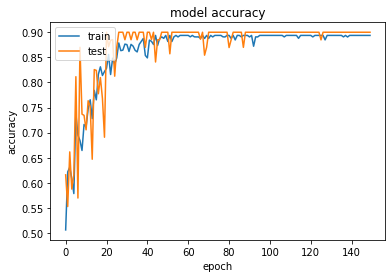

'\nprediction_mean = prediction_distribution.mean().tolist()\nprediction_stdv = prediction_distribution.std()\n\n# The 95% CI is computed as mean ± (1.96 * stdv)\nupper = (prediction_mean + (1.96 * prediction_stdv)).tolist()\nlower = (prediction_mean - (1.96 * prediction_stdv)).tolist()\nprediction_stdv = prediction_stdv.tolist()\n\nprint(prediction_mean)\n\nfor idx in range(10):\n    print(\n        f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "\n        f"stddev: {round(prediction_stdv[idx][0], 2)}, "\n        f"95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}]"\n        #f" - Actual: {y_copy.iloc[idx]}"\n    )'

In [137]:
list_final = list(range(300))
prediction_distribution = prob_bnn_model.predict(list_final)
#print(X_test)
#print(prediction_distribution)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

"""
prediction_mean = prediction_distribution.mean().tolist()
prediction_stdv = prediction_distribution.std()

# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()

print(prediction_mean)

for idx in range(10):
    print(
        f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv[idx][0], 2)}, "
        f"95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}]"
        #f" - Actual: {y_copy.iloc[idx]}"
    )"""

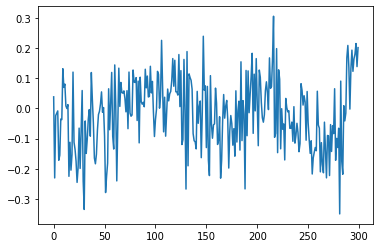

In [139]:
plt.plot(list_final, prediction_distribution)
plt.show()

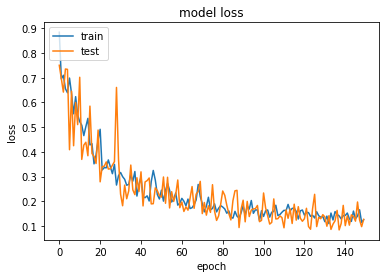

In [132]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [102]:
print(y_test)
i = 0
for pred in prediction_distribution:
    m = np.argmax(pred)
    print(pred)
    i += 1
print(i)

"""
for i in range(len(X_test)):
    print("Predicted song after song nº ", X_test[i], ": ")
    pred = np.argmax(prediction_distribution[i])
    print(pred)"""

     0    1    2    3    4    5    6    7    8    9    ...       290  \
97   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
40   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
233  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
130  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
189  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
142  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
9    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
104  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
234  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
264  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.009615   
287  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.111111   
36   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.000000   
235  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.00

'\nfor i in range(len(X_test)):\n    print("Predicted song after song nº ", X_test[i], ": ")\n    pred = np.argmax(prediction_distribution[i])\n    print(pred)'

In [161]:
model = create_model()
callback1 = callbacks.EarlyStopping(monitor='loss', patience=5)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#history = model.fit(train_dataset, epochs=1000, validation_data=test_dataset, verbose=1)
history = model.fit(x=X_train3, y=y_train3, epochs=200, validation_data=(X_test3,y_test3))

Epoch 1/200
1500/1500 [==============================] - 1s 666us/step - loss: nan - accuracy: 0.0141 - val_loss: nan - val_accuracy: 0.0143
Epoch 2/200
1500/1500 [==============================] - 1s 607us/step - loss: nan - accuracy: 0.0142 - val_loss: nan - val_accuracy: 0.0143
Epoch 3/200
1500/1500 [==============================] - 1s 606us/step - loss: nan - accuracy: 0.0142 - val_loss: nan - val_accuracy: 0.0143
Epoch 4/200
1500/1500 [==============================] - 1s 616us/step - loss: nan - accuracy: 0.0142 - val_loss: nan - val_accuracy: 0.0143
Epoch 5/200
1500/1500 [==============================] - 1s 586us/step - loss: nan - accuracy: 0.0142 - val_loss: nan - val_accuracy: 0.0143
Epoch 6/200
1500/1500 [==============================] - 1s 591us/step - loss: nan - accuracy: 0.0142 - val_loss: nan - val_accuracy: 0.0143
Epoch 7/200
1500/1500 [==============================] - 1s 588us/step - loss: nan - accuracy: 0.0142 - val_loss: nan - val_accuracy: 0.0143
Epoch 8/200
1

In [162]:
prueba2 = list(range(300))
predic = model.predict(prueba2)
numbs = []
for dist in predic:
    n = np.argmax(dist)
    numbs.append(n)
numbs

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
